In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm 
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [2]:

def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def flip(imagelist, axis=1):
    """Randomly flip spatial dimensions

    Args:
        imagelist (np.ndarray or list or tuple): image(s) to be flipped
        axis (int): axis along which to flip the images

    Returns:
        np.ndarray or list or tuple: same as imagelist but randomly flipped
            along axis
    """

    # Check if a single image or a list of images has been passed
    was_singular = False
    if isinstance(imagelist, np.ndarray):
        imagelist = [imagelist]
        was_singular = True

    # With a probility of 0.5 flip the image(s) across `axis`
    for i in range(len(imagelist)):
        imagelist[i] = np.flip(imagelist[i], axis=axis)
    if was_singular:
        return imagelist[0]
    return imagelist

In [4]:
base_data_path = r"D:\data\DICOM_secha\DICOM_xy_position\Nii_files"
df_path = os.path.join(base_data_path, 'slices.xlsx')
df = pd.read_excel(df_path)
df = df[df.Name != "KURDUMOV.nii"] # broken file
df['Name'] = df.Name.apply(lambda x: os.path.join(base_data_path, x))
df

,Name,Begin,End1vertebra,End2vertebra,Sex,Age,x_center,y_center,Strange Scale Data
0,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,56,4,NONE,m,26,273,293,0
1,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,94,54,14,f,18,261,313,0
2,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,157,116,75,f,25,259,346,0
3,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,328,284,240,m,30,250,285,0
4,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,291,248,209,m,35,231,327,0
...,...,...,...,...,...,...,...,...,...
219,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,71,29,NONE,f,37,260,310,0
220,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,90,44,NONE,NONE,45,261,332,0
221,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,91,49,6,NONE,39,259,263,0
222,D:\data\DICOM_secha\DICOM_xy_position\Nii_file...,85,41,6,f,42,260,278,0


In [ ]:
shapes = dict()
for fp in tqdm(df.Name.tolist()):
    image = sitk.GetArrayFromImage(sitk.ReadImage(fp)).astype(np.float32)
    shapes[fp] = image.shape

In [ ]:
df['tgt_b'] = 0
df['tgt_x'] = 0
df['tgt_y'] = 0

for fp in shapes:
    df.loc[df.Name==fp, 'tgt_b'] = df[df.Name==fp].Begin / shapes[fp][0]
    df.loc[df.Name==fp, 'tgt_x'] = df[df.Name==fp].x_center / shapes[fp][2]
    df.loc[df.Name==fp, 'tgt_y'] = df[df.Name==fp].y_center / shapes[fp][1]
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df.tgt_b)
plt.show()

sns.distplot(df.tgt_x)
plt.show()

sns.distplot(df.tgt_y)
plt.show()

In [157]:
sum(df.x_center.isnull()), sum(df.y_center.isnull())

(0, 0)

(240, 512, 512)


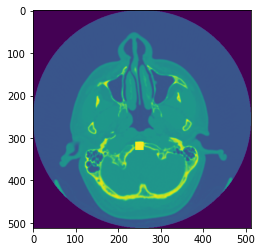

In [199]:
i = 150
delta = 10
fp = df.Name[i]
begin = df.Begin[i]
x = df.x_center[i]
y = df.y_center[i]

image = sitk.GetArrayFromImage(sitk.ReadImage(fp)).astype(np.float32)
# image = whitening(image)
# image = np.expand_dims(image, axis=-1).astype(np.float32)

# image = flip(image, 3)
print(image.shape)
image[begin, y-delta:y+delta, x-delta:x+delta] = image[begin].max()
plt.imshow(image[begin])

In [173]:
image.max()

14.800061

torch.Size([1, 280, 512, 512])


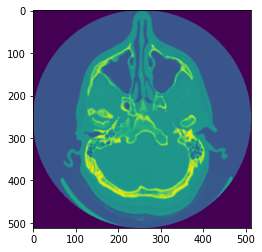

torch.Size([1, 280, 512, 512])
torch.Size([1, 280, 512, 512])


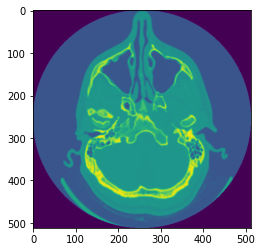

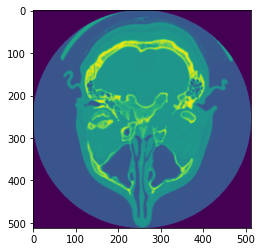

In [19]:
def resample_image(image, depth): # (N, C, d,h,w)
    d = torch.linspace(-1, 1, depth)
    h = torch.linspace(-1, 1, image.shape[-2])
    w = torch.linspace(-1, 1, image.shape[-1])
    meshx, meshy, meshz = torch.meshgrid((d,h,w))
    grid = torch.stack((meshz, meshy, meshx), 3)
    grid = grid.unsqueeze(0) # add batch dim
    image = F.grid_sample(image, grid, align_corners=True)
    return image.squeeze(0) # returns (ch, d, h, w)

file_path = df.loc[0, 'Name']
image = sitk.GetArrayFromImage(sitk.ReadImage(file_path)).astype(np.float32)
image = torch.tensor(image).type(torch.FloatTensor).unsqueeze(0)
print(image.shape)


plt.imshow(image[0, 100, :, :])
plt.show()

print(image.shape)
image = resample_image(image.unsqueeze(0), 280)
print(image.shape)
plt.imshow(image[0, 100, :, :])
plt.show()

plt.imshow(torch.flip(image, [2])[0, 100, :, :])
plt.show()

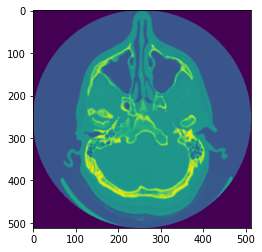

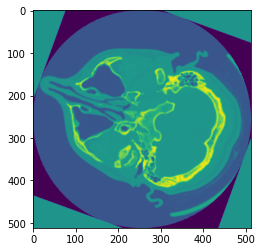

In [201]:
file_path = df.loc[0, 'Name']
image = sitk.GetArrayFromImage(sitk.ReadImage(file_path)).astype(np.float32)
image = torch.tensor(image).type(torch.FloatTensor).unsqueeze(0)


plt.imshow(image[0, 100, :, :])
plt.show()


plt.imshow(TF.rotate(image, 70)[0, 100, :, :])
plt.show()

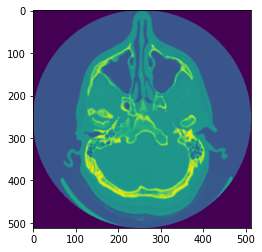

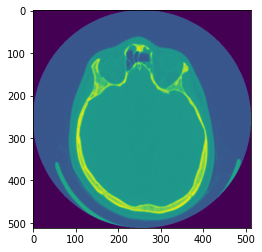

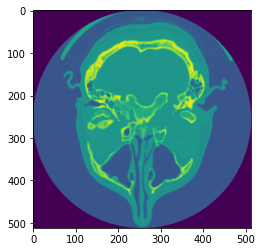

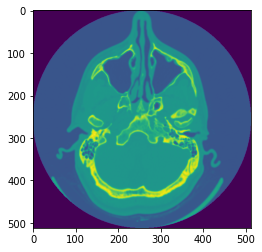

In [104]:
file_path = df.loc[0, 'Name']
image = sitk.GetArrayFromImage(sitk.ReadImage(file_path)).astype(np.float32)
image = torch.tensor(image).unsqueeze(0)
# image = image[:, :150, :, :]

plt.imshow(image[0, 100, :, :])
plt.show()

plt.imshow(torch.flip(image, [1,])[0, 100, :, :])
plt.show()

plt.imshow(torch.flip(image, [2])[0, 100, :, :])
plt.show()

plt.imshow(torch.flip(image, [3])[0, 100, :, :])
plt.show()

In [16]:
import random


2

torch.Size([1, 128, 349, 312]) tensor([0.2759, 0.6476, 0.4071])


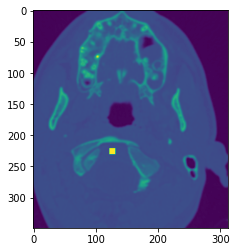

In [40]:
import random

class DICOMDataset(Dataset):
    def __init__(self, df, out_size=256, mode='test', verbose=False):
        self.df = df
        self.out_size = out_size
        self.mode = mode
        self.verbose = verbose

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        file_path = df.loc[i, 'Name'] 
        image = sitk.GetArrayFromImage(sitk.ReadImage(file_path)).astype(np.float32) # (d,h,w)
        image = whitening(image) # (d,h,w)

        begin = df.loc[i, 'Begin']
        hc = df.y_center[i]
        wc = df.x_center[i]

        margin_proba = 0.7
        if self.mode == 'train':
            if random.uniform(0,1)<margin_proba:
                # slice axis 0 begin down
                margin = random.randint(1, int(begin*0.5))
                begin -= margin
                image = image[margin:, :,:]
                
            if random.uniform(0,1)<margin_proba:
                # slice axis 0 begin up
                margin = random.randint(1, int((image.shape[0]-begin)*0.5))
                image = image[:-margin, :,:]
                
                
            if random.uniform(0,1)<margin_proba:
                # slice axis 1 hc down
                margin = random.randint(1, int(hc*0.5))
                hc -= margin
                image = image[:, margin:, :]

            if random.uniform(0,1)<margin_proba:
                # slice axis 1 hc up
                margin = random.randint(1, int((image.shape[1]-hc)*0.5))
                image = image[:, :-margin, :]

            
            if random.uniform(0,1)<margin_proba:
                # slice axis 2 wc down
                margin = random.randint(1, int(wc*0.5))
                wc -= margin
                image = image[:, :, margin:]                
                
            if random.uniform(0,1)<margin_proba:
                # slice axis 2 wc up
                margin = random.randint(1, int((image.shape[2]-wc)*0.5))
                image = image[:, :, :-margin]
        
#         if False and self.out_height > image.shape[0] and random.uniform(0,1)<0.3:
#             # slice
#             image = torch.tensor(image).type(torch.FloatTensor).unsqueeze(0)
#             image = image[:, self.out_height, :, :]
        
#         elif False and self.out_height < image.shape[0] and random.uniform(0,1)<0.3:
#             # as is
#             image = torch.tensor(image).type(torch.FloatTensor).unsqueeze(0)
            
        begin /= image.shape[0]
        hc /= image.shape[1]
        wc /= image.shape[2]
    
        # resample
        image  = torch.tensor(image).type(torch.FloatTensor).unsqueeze(0)
        image = resample_image(image.unsqueeze(0), self.out_size)
    
        
#         image = torch.flip(image, [1])
        
        # flips
        if self.mode == 'train':
            if random.uniform(0,1)<0.5:
                image = torch.flip(image, [1])
                begin = 1-begin
                if self.verbose: print('depth flip')

            if random.uniform(0,1)<0.5:
                image = torch.flip(image, [2])
                hc = 1-hc
                if self.verbose: print('height flip')
            
            if random.uniform(0,1)<0.5:
                image = torch.flip(image, [3])
                wc = 1-wc
                if self.verbose: print('width flip')

            
            
        target = torch.tensor([begin, hc, wc]).type(torch.FloatTensor)
        return image, target

    

ds = DICOMDataset(df, 128, 'train')
image, tgt = ds[0]
print(image.shape, tgt)

# plt.imshow(img[0, 100, :, :])
delta = 5
begin = int(tgt[0]*image.shape[1])
hc = int(tgt[1]*image.shape[2])
wc = int(tgt[2]*image.shape[3])
image[0, begin, hc-delta:hc+delta, wc-delta:wc+delta] = image[0, begin].max()
plt.imshow(image[0, begin])

# i = 150
# delta = 10
# fp = df.Name[i]
# begin = df.Begin[i]
# x = df.x_center[i]
# y = df.y_center[i]

# image = sitk.GetArrayFromImage(sitk.ReadImage(fp)).astype(np.float32)
# # image = whitening(image)
# # image = np.expand_dims(image, axis=-1).astype(np.float32)

# # image = flip(image, 3)
# print(image.shape)

